# Initial

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import itertools
from collections import Counter

from combat.pycombat import pycombat

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.feature_selection import RFE

from xgboost import XGBClassifier
from time import time
from sklearn.impute import SimpleImputer

## Code

### Fixing Datasets

In [2]:
def import_csv_files(path, starts_with, ends_with = ".csv"):
    """Imports csv files based on path and starting characters.

    :param path: Path of where to find csv files.
    :param starts_with: Starting characters of dataframes to find.
    :param ends_with: Type of file to load.
    
    :return: List of loaded csv files."""    
    file_list = []
    for filename in os.listdir(path):
        if filename.startswith(starts_with) and filename.endswith(ends_with):
            file_path = os.path.join(path, filename)
            file_list.append(pd.read_csv(file_path))
    return file_list

In [3]:
def same_shape(dfs : list):
    """Checks if all dataframes in a list have the same shape.

    :param dfs: List of dataframes.
    
    :return: Boolean value if all dataframes have the same shape."""    
    return all(df.shape == dfs[0].shape for df in dfs)

In [4]:
def get_average_from_m_datasets(dfs : list):
    """Pools imputed dataset into a single dataframe.

    :param dfs: List of dataframes.
    
    :return: Singular, pooled dataframe."""    
    if not same_shape:
        print("Dataframes must have the same shape")
    joined = pd.concat(dfs).reset_index() 
    return joined.groupby('index').mean()

In [5]:
def make_binary(df, y, keepers):
    """Removes classes from df and y that are not present in var keepers.

    :param df: dataframe (X in classification task)
    :param y: class labels
    :param keepers: labels that we want to keep
    :return: X and y without labels not present in keepers
    """    
    mask = y.isin(keepers)
    y = y[mask].reset_index(drop=True)
    df = df[mask].reset_index(drop=True)
    return df, y

### Cleaning and Perturbation

In [6]:
def run_combat(df, TMT_set_indices):
    """Run ComBat to reduce batch effect on a dataframe.

    :param df: Dataframe that ComBat is runned on.
    :param TMT_set_indices: Labels of which TMT batch each row belongs to.
    
    :return: DF with ComBat applied to it."""    
    return pycombat(df.T, TMT_set_indices).T

In [7]:
def add_noise(df, n_samples, std = 0.1):
    """Helper function for simple perturbation function. Adds gaussian noise to randomly sampled rows of the df passed as an argument.

    :param df: df filtered on class.
    :param n_samples: Number of samples to perform random sampling on.
    :param std: Standard deviation. Defaults to 0.1.
    
    :return: df with added perturbed samples."""      
    sampled_df = df.sample(n = n_samples, replace = True)
    gaussian_noise = np.random.normal(0, std, size=sampled_df.shape)
    return sampled_df + gaussian_noise

In [8]:
def simple_perturbation(X, y, n_samples_per_class = None, std = 0.1):
    """Performs a simple perturbation by sampling random rows of classes and adds gaussian noise to them

    :param X: Dataframe with samples to get perturbed.
    :param y: Class labels.
    :param n_samples_per_class: Decides how many samples per class that are going to be sampled, defaults to None. 
    If none -> all classes will get equal weight according to size of current largest class.
    :param std: How much the noise can deviate from the mean (Standard dev.), defaults to 0.1
    
    :return: A df with the perturbed samples. A list stating which row belongs to which class."""    
    classes = y.value_counts()
    if n_samples_per_class is None:
        largest_class = classes.argmax()
        largest_n_samples = classes.pop(largest_class)
    else:
        largest_n_samples = n_samples_per_class
    df_list = []
    y_new_classes = list(y)
    for idx, n_samples in classes.items():
        perturbed = add_noise(X[y == idx], largest_n_samples - n_samples, std=std)
        df_list.append(perturbed)
        y_new_classes = y_new_classes + [idx] * len(perturbed)
    return pd.concat([X] + df_list, axis=0), y_new_classes

### GridSearch and Feature Importance

In [9]:
def get_best_params(X, y, models, params, cv = 5, n_jobs = -1):
    """Runs GridSearchCV in order to find best parameters on one or more models.

    :param X: The training data for the models.
    :param y: The correct classification of the training data.
    :param models: A list of models to be trained.
    :param params: A dictionary with the parameters for each model to be GridSearched.
    :param cv: The K-fold cross validation value.
    :param n_jobs: Number of cores to use for GridSearchCV.
    
    :return: DF with ComBat applied to it."""   
    best_params = {}
    for model, param in zip(models, params):
        start_time = time()
        print(f"\033[97m{model.name} started.")
        clf = GridSearchCV(model, param_grid=param, cv=cv, n_jobs=n_jobs, scoring="f1")
        clf.fit(X, y)
        best_params[model.name] = clf.best_params_
        print(f"{model.name} is done in {time() - start_time} seconds.\n" )
    return best_params

In [10]:
def get_best_params_bayes(X, y, models, params, n_iter = 50, cv = 3, n_jobs = -1):
    """Runs GridSearchCV in order to find best parameters on one or more models.

    :param X: The training data for the models.
    :param y: The correct classification of the training data.
    :param models: A list of models to be trained.
    :param params: A dictionary with the parameters for each model to be GridSearched.
    :param cv: The K-fold cross validation value.
    :param n_jobs: Number of cores to use for GridSearchCV.

    :return: DF with ComBat applied to it"""   
    best_params = {}
    for model, param in zip(models, params):
        start_time = time()
        print(f"\033[97m{model.name} started.")
        clf = BayesSearchCV(model, search_spaces=param, n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring="f1")
        clf.fit(X, y)
        best_params[model.name] = clf.best_params_
        print(f"{model.name} is done in {time() - start_time} seconds.\n" )
    return best_params

In [11]:
def get_average_feature_importance_XGB_RF(models, df):
    """Extracts feature importance from the same models over multiple iterations, averaging them over each iteration.

    :param models: Models to extract feature importance from.
    :param df: Original dataframe in order to map feature importances to column names.
    
    :return: Dictionary with column name as keys and average feature importance as values."""  
    avg_feature_importance = {}
    for model in models:
        importances = model.feature_importances_
        for index, importance in enumerate(importances):
            name = df.columns[index]
            if name in avg_feature_importance:
                avg_feature_importance[name] += importance
            else:
                avg_feature_importance[name] = importance
    for feature, total in avg_feature_importance.items():
        mean = total / len(models)
        avg_feature_importance[feature] = mean
    
    return avg_feature_importance

In [12]:
def get_average_feature_importance_LR(models, df):
    """Extracts feature importance from the same models over multiple iterations, averaging them over each iteration.

    :param models: Models to extract feature importance from.
    :param df: Original dataframe in order to map feature importances to column names.
    
    :return: Dictionary with column name as keys and average feature importance as values."""  
    all_coefficients = []
    feature_names = df.columns.tolist()
    max_length = max(len(model.coef_[0]) for model in models)
    
    for model in models:
        coefficients = model.coef_[0]
        padded_coefficients = np.pad(coefficients, (0, max_length - len(coefficients)), mode='constant', constant_values=np.nan)
        all_coefficients.append(padded_coefficients)

    avg_coefficients = np.nanmean(all_coefficients, axis=0) 
    normalized_coefficients = avg_coefficients / np.nansum(avg_coefficients)
    feature_importance = dict(zip(feature_names, normalized_coefficients))
    
    return feature_importance


In [13]:
def get_average_feature_importance(d, model_name, df):
    """Wrapper function in order to extract average feature importance across multiple iterations of multiple models.

    :param d: Dictionary with models.
    :param model_name: Name of the model.
    :param df: Original dataframe in order to map feature importances to column names.
    
    :return: Dictionary with column name as keys and average feature importance as values."""  
    models = [model for key, model in d.items() if key.startswith(f'{model_name}')]
    if model_name == "LR":
        return get_average_feature_importance_LR(models, df)
    return get_average_feature_importance_XGB_RF(models, df)

In [14]:
def calculate_average(dictionaries):
    """Gets the average feature importance from multiple dictionaries
    
    :param dictionaries: List of dictionaries to be averaged.

    :return: Dictionary with averaged values."""
    sum_values = {}
    count_values = {}
    
    for dictionary in dictionaries:
        for key, value in dictionary.items():
            if key not in sum_values:
                sum_values[key] = 0
                count_values[key] = 0
            sum_values[key] += value
            count_values[key] += 1
    
    averages = {}
    for key, total_sum in sum_values.items():
        averages[key] = total_sum / count_values[key]
    
    return averages

### Voting

In [15]:
def hard_voting(models):
    """Hard voting based on predictions from multiple models.

    :param models: List of trained models.
    
    :return: Hard voting results."""  
    predictions = [model.prediction for model in models]
    predictions = [[row[i] for row in predictions] for i in range(len(predictions[0]))]
    results = []
    for index, p in enumerate(predictions):
        most_common = Counter(p).most_common()
        if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
            probabilities = [model.probability[index] for model in models]
            probabilities = [[row[i] for row in probabilities] for i in range(len(probabilities[0]))]
            probabilities = [sum(sublist) for sublist in probabilities]
            if len(most_common) > 2 and most_common[0][1] == most_common[2][1]:
                results.append(np.argmax(probabilities))
            else:
                probabilities[most_common[2][0]] = 0
                results.append(np.argmax(probabilities))
        else:
            results.append(most_common[0][0])

    return results  

In [16]:
def soft_voting(models):
    """Soft voting based on predictions from multiple models.

    :param models: List of trained models.
    
    :return: Soft voting results."""  
    probabilities = [model.probability for model in models]
    summed_probabilities = np.sum(probabilities, axis=0)

    results = np.argmax(summed_probabilities, axis=1)

    return results

### Plotting Code

In [17]:
def staging(df_lumbar, df_ventricular, y_lumbar, y_ventricular, feature):
    """Plots boxplot staging of feature based on analyte and pathology.

    :param df_lumbar: The lumbar part of the dataset.
    :param df_ventricular: The ventricular part of the dataset.
    :param y_lumbar: The lumbar part of the pathology class.
    :param y_ventricular: The ventricular part of the pathology class.
    :param feature: The protein or peptide that should be visualized."""
    cn_pathology = "A\u207BT\u207B"
    mci_pathology = "A\u207AT\u207B"
    ad_pathology = "A\u207AT\u207A"

    df_lumbar["CSF_type"] = "Lumbar"
    df_ventricular["CSF_type"] = "Ventricular"

    df_merged = pd.concat([df_ventricular, df_lumbar], ignore_index=True)
    y_merged = pd.concat([y_lumbar, y_ventricular], ignore_index=True)
    y_merged = y_merged.replace(0, cn_pathology)
    if len(y_merged.value_counts()) > 2:
        y_merged = y_merged.replace(1, mci_pathology)
    y_merged = y_merged.replace(len(y_merged.value_counts())-1, ad_pathology)
    
    if len(y_merged.value_counts()) > 2:
        sns.boxplot(data=df_merged, x="CSF_type", y=feature, hue=y_merged, hue_order=[cn_pathology, mci_pathology, ad_pathology]);
    else: 
        sns.boxplot(data=df_merged, x="CSF_type", y=feature, hue=y_merged, hue_order=[cn_pathology, ad_pathology]);

In [18]:
def plot_percentiles(percentiles, labels, title="Accuracy scores", ax=None):
    """Plot percentiles against labels.

    :param percentiles: List of percentiles.
    :param labels: List of strings (labels).
    :param title: Title of the plot.
    :param ax: Axes object to plot on."""
    x = range(len(labels))
    if ax is None:
        plt.figure(figsize=(8, 6))
        ax = plt.gca()

    ax.bar(x, percentiles, color='skyblue')
    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 1)
    plt.show()


In [19]:
def plot_feature_importance(dict0, dict1, dict2, dict3, models=["Average","Model1", "Model2", "Model3"], main_model = None, colours = ["tab:cyan", "tab:blue", "tab:orange", "tab:olive"]):
    """Plots feature importance from three dictionaries.

    :param dict: 
    :param labels: List of strings (labels)."""
    sorted_dict0 = dict(sorted(dict0.items(), key=lambda item: item[1], reverse=True))
    top_features_dict0 = list(sorted_dict0.items())[:5]
    top_features_keys = [key for key, _ in top_features_dict0]

    feature_importance_dict0 = [val for _, val in top_features_dict0]
    feature_importance_dict1 = [dict1[key] for key in top_features_keys]
    feature_importance_dict2 = [dict2[key] for key in top_features_keys]
    feature_importance_dict3 = [dict3[key] for key in top_features_keys]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar([i - 0.3 for i in range(5)], feature_importance_dict0, width=0.2, color=colours[0], label=models[0])
    ax.bar([i - 0.1 for i in range(5)], feature_importance_dict1, width=0.2, color=colours[1], label=models[1])
    ax.bar([i + 0.1 for i in range(5)], feature_importance_dict2, width=0.2, color=colours[2], label=models[2])
    ax.bar([i + 0.3 for i in range(5)], feature_importance_dict3, width=0.2, color=colours[3], label=models[3])

    ax.set_xticks(range(5))
    ax.set_xticklabels(top_features_keys, rotation=90)
    ax.set_xlabel('Features')
    ax.set_ylabel('Importance')
    ax.set_title(f"Top 5 out of {len(sorted_dict0)} averaged features from {models[1]}, {models[2]} and {models[3]}.")
    ax.legend()

    plt.tight_layout()
    plt.show()

In [20]:
def plot_confusion_matrix(ax, cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """Plots a confusion matrix.

    :param ax: Axis to print confusion matrix on.
    :param cm: Pre-made sklearn confusion matrix.
    :param classes: Values of predicted classes.
    :param normalize: If True, normalizes the values between 0 and 1.
    :param title: Title of confusion matrix.
    :param cmap: Colour of confusion matrix.""" 
    class_labels = ["CN", "AD"]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_labels, rotation=45) 
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')


In [21]:
def plot_vote_confusion_matrix(y_predictions, y_real, names, title="Confusion Matrix"):
    """Plot confusion matrices for multiple models along with accuracy scores.

    :param y_predictions: A list of lists where each inner list contains predictions for a model.
    :param y_real: The real y values.
    :param names: A list containing names of the models.
    :param title: Title of the plot."""
    num_models = len(y_predictions)
    num_classes = len(set(y_real))
    
    num_rows = 2
    num_cols = 3

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 12))

    for i, ax in enumerate(axs.flat[:-1]):
        if i < num_models:
            cnf_matrix = confusion_matrix(y_real, y_predictions[i])
            ax.set_title(names[i])
            plot_confusion_matrix(ax, cnf_matrix, classes=range(num_classes), title=names[i])

    percentiles = [accuracy_score(y_real, y_predictions[0]),
                   accuracy_score(y_real, y_predictions[1]),
                   accuracy_score(y_real, y_predictions[2]),
                   accuracy_score(y_real, y_predictions[3]),
                   accuracy_score(y_real, y_predictions[4])]
    labels = ["Hard Vote", "Soft Vote", "XGB", "LR", "RF"]
    plot_percentiles(percentiles, labels, "Accuracy on validation data in K-fold.", ax=axs[-1, -1])

    plt.show()


In [22]:
def get_roc_auc(y_test, y_scores_list):
    """Plots roc_auc for a model.

    :param y_test: A list of y used during k-fold validation.
    :param y_scores_list: The predicted y values."""
    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)
    models = ["XGB", "LR", "RF"]
    for i, y_scores in enumerate(y_scores_list):
        y_scores = np.array([array[1] for array in y_scores])
        auc_score = roc_auc_score(y_onehot_test, y_scores)

        display = RocCurveDisplay.from_predictions(
            y_onehot_test.ravel(),
            y_scores.ravel(),
            name=f"Model {models[i]}",
            color=f"C{i}",
            plot_chance_level=True,
        )
        _ = display.ax_.set(
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            title=f"{models[i]} ROC",
        )

In [43]:
def get_scores(models, votes, y_true, get_graphs=False):
    """Plots AUC, ACC and F1 from all models and hard/soft votes.

    :param models: Dict with all models.
    :param votes: Dict with all votes from the models.
    :param y_true: The y values across the K-fold validation.
    :param get_graphs: If set to true, prints confusion matrix and roc curve."""
    hard_votes = [item for sublist in [value for key, value in votes.items() if key.startswith('Hard')] for item in sublist]
    soft_votes = [item for sublist in [value for key, value in votes.items() if key.startswith('Soft')] for item in sublist]
    xgb_votes = [item for sublist in [value.prediction for key, value in models.items() if key.startswith('XGB')] for item in sublist]
    lr_votes = [item for sublist in [value.prediction for key, value in models.items() if key.startswith('LR')] for item in sublist]
    rf_votes = [item for sublist in [value.prediction for key, value in models.items() if key.startswith('RF')] for item in sublist]
    xgb_prob = [item for sublist in [value.probability for key, value in models.items() if key.startswith('XGB')] for item in sublist]
    lr_prob = [item for sublist in [value.probability for key, value in models.items() if key.startswith('LR')] for item in sublist]
    rf_prob = [item for sublist in [value.probability for key, value in models.items() if key.startswith('RF')] for item in sublist]
    xgb_prob_1 = np.array([array[1] for array in xgb_prob])
    lr_prob_1 = np.array([array[1] for array in lr_prob])
    rf_prob_1 = np.array([array[1] for array in rf_prob])
    soft_prob_pre = np.stack([xgb_prob_1, lr_prob_1, rf_prob_1], axis=0)
    soft_prob_1 = np.mean(soft_prob_pre, axis=0)
    y_trues = [item for sublist in [list(series) for series in y_true.values()] for item in sublist]

    def format_line(label, auc_ovr, acc, f1):
        return f"{label:<10}\tAUC OVR: {auc_ovr:<20}\tACC: {acc:<20}\tF1: {f1}"

    print(format_line("XGB", roc_auc_score(y_trues, xgb_prob_1), accuracy_score(y_trues, xgb_votes), f1_score(y_trues, xgb_votes)))
    print(format_line("LR", roc_auc_score(y_trues, lr_prob_1), accuracy_score(y_trues, lr_votes), f1_score(y_trues, lr_votes)))
    print(format_line("RF", roc_auc_score(y_trues, rf_prob_1), accuracy_score(y_trues, rf_votes), f1_score(y_trues, rf_votes)))

    print(format_line("Soft Vote", roc_auc_score(y_trues, soft_prob_1), accuracy_score(y_trues, soft_votes), f1_score(y_trues, soft_votes)))
    print(format_line("Hard Vote", roc_auc_score(y_trues, soft_prob_1), accuracy_score(y_trues, hard_votes), f1_score(y_trues, hard_votes)))

    if get_graphs:
        y_predictions = [hard_votes, soft_votes, xgb_votes, lr_votes, rf_votes]
        model_names = ["Hard Votes", "Soft Votes", "XGBoost", "Logistic Regression", "Random Forest"]
        plot_vote_confusion_matrix(y_predictions, y_trues, model_names)
        get_roc_auc(y_trues, [xgb_prob, lr_prob, rf_prob])

### Main Pipeline

In [24]:
def get_union_features(state, n_features, df, y):
    """Quick and dirty solution to get DF union during k-fold validations.

    :param state: Dict with all models.
    :param n_features: Dict with all votes from the models.
    :param df: The y values across the K-fold validation.
    :param y: The y values across the K-fold validation.

    :return: Dataframe with df_union feature selection."""    
    lasso = Lasso(alpha=0.001, max_iter=5000, random_state=state)
    lr = LogisticRegression(penalty='elasticnet', solver="saga", multi_class="multinomial", max_iter=8000, C=0.01, l1_ratio=0.8, random_state=state)
    rf = RandomForestClassifier(n_estimators=350, criterion='gini', max_depth=10, max_features='sqrt', min_samples_leaf=1, random_state=state)
    xgb = XGBClassifier(eta=0.2, gamma=0.01, n_estimators=150, reg_lambda=0.85, max_depth=5, min_child_weight=0.45, subsample=0.6, seed=state)

    n_features_p0 = 500
    step_p0 = 50

    #LASSO
    rfe_lasso0 = RFE(lasso, n_features_to_select=n_features_p0, step=step_p0)
    _ = rfe_lasso0.fit_transform(df, y=y)

    #LR
    rfe_lr0 = RFE(lr, n_features_to_select=n_features_p0, step=step_p0)
    _ = rfe_lr0.fit_transform(df, y=y)

    #RF
    rfe_rf0 = RFE(rf, n_features_to_select=n_features_p0, step=step_p0)
    _ = rfe_rf0.fit_transform(df, y=y)

    #XGB
    rfe_xgb0 = RFE(xgb, n_features_to_select=n_features_p0, step=step_p0)
    _ = rfe_xgb0.fit_transform(df, y=y)

    #Feature Names.
    lasso_cont0 = rfe_lasso0.get_feature_names_out()
    lr_cont0 = rfe_lr0.get_feature_names_out()
    rf_cont0 = rfe_rf0.get_feature_names_out()
    xgb_cont0 = rfe_xgb0.get_feature_names_out()

    #Dataframes based on extracted features.
    df_lasso_cont0 = df[lasso_cont0]
    df_lr_cont0 = df[lr_cont0]
    df_rf_cont0 = df[rf_cont0]
    df_xgb_cont0 = df[xgb_cont0]

    n_features_p1 = 100
    step_p1 = 10

    #LASSO
    rfe_lasso1 = RFE(lasso, n_features_to_select=n_features_p1, step=step_p1)
    _ = rfe_lasso1.fit_transform(df_lasso_cont0, y=y)

    #LR
    rfe_lr1 = RFE(lr, n_features_to_select=n_features_p1, step=step_p1)
    _ = rfe_lr1.fit_transform(df_lr_cont0, y=y)

    #RF
    rfe_rf1 = RFE(rf, n_features_to_select=n_features_p1, step=step_p1)
    _ = rfe_rf1.fit_transform(df_rf_cont0, y=y)

    #XGB
    rfe_xgb1 = RFE(xgb, n_features_to_select=n_features_p1, step=step_p1)
    _ = rfe_xgb1.fit_transform(df_xgb_cont0, y=y)

    #Feature Names.
    lasso_cont1 = rfe_lasso1.get_feature_names_out()
    lr_cont1 = rfe_lr1.get_feature_names_out()
    rf_cont1 = rfe_rf1.get_feature_names_out()
    xgb_cont1 = rfe_xgb1.get_feature_names_out()

    #Dataframes based on extracted features.
    df_lasso_cont1 = df[lasso_cont1]
    df_lr_cont1 = df[lr_cont1]
    df_rf_cont1 = df[rf_cont1]
    df_xgb_cont1 = df[xgb_cont1]

    #PART 2
    n_features_p2 = n_features
    step_p2 = 1

    #LASSO
    rfe_lasso_p2 = RFE(lasso, n_features_to_select=n_features_p2, step=step_p2)
    _ = rfe_lasso_p2.fit_transform(df_lasso_cont1, y=y)

    #LR
    rfe_lr_p2 = RFE(lr, n_features_to_select=n_features_p2, step=step_p2)
    _ = rfe_lr_p2.fit_transform(df_lr_cont1, y=y)

    #RF
    rfe_rf_p2 = RFE(rf, n_features_to_select=n_features_p2, step=step_p2)
    _ = rfe_rf_p2.fit_transform(df_rf_cont1, y=y)

    #XGB
    rfe_xgb_p2 = RFE(xgb, n_features_to_select=n_features_p2, step=step_p2)
    _ = rfe_xgb_p2.fit_transform(df_xgb_cont1, y=y)

    #Number of features in current dataset.
    set_lasso_p2 = set(rfe_lasso_p2.get_feature_names_out())
    set_lr_p2 = set(rfe_lr_p2.get_feature_names_out())
    set_rf_p2 = set(rfe_rf_p2.get_feature_names_out())
    set_xgb_p2 = set(rfe_xgb_p2.get_feature_names_out())

    #Dataset after feature extraction.
    set_union = set_lasso_p2.union(set_lr_p2, set_rf_p2, set_xgb_p2)
    list_union = list(set_union)
    df_union = df[list_union]

    return df_union

In [25]:
def create_models(iteration):
    """Creates 3 new basemodels with names depending on iteration.

    :param iteration: Current iteration in K-Fold cross validation.
    
    :return: List of base models."""      
    xgboost = XGBClassifier()
    xgboost.name = f"XGB {iteration}"
    lr = LogisticRegression()
    lr.name = f"LR {iteration}"
    rf = RandomForestClassifier()
    rf.name = f"RF {iteration}"

    return [xgboost, lr, rf]

In [26]:
def find_mean_and_top_features(X, y):
    """Finds the features with highest variance in mean value between the y classes.
    
    :param X: Dataframe with X values.
    :param y: Pandas series with target values.
    
    :return: List with the highets variance features."""
    df = pd.concat([X, y], axis=1)
    means = df.groupby(y.name).mean()
    means_X = means.iloc[:, :-1]
    feature_variances = {}
    
    for feature in means_X.columns:
        sorted_vals = np.sort(means_X[feature])
        variance = np.var(sorted_vals)
        feature_variances[feature] = variance
    
    top_features = sorted(feature_variances, key=feature_variances.get, reverse=True)[:5]
    
    return top_features

In [27]:
def pipeline(X, y, params, K = 5, n_samples_per_class = 41, bayes = False, corruption = False, union_n = 15):
    """Main pipeline code that runs K-fold validation.

    :param X: Dataframe of X values for training.
    :param y: Pandas series of real class values for training 
    :param params: Parameter settings to get best parameters from.
    :param K: Number of K-fold iterations to run.
    :param n_samples_per_class: Number of samples per class that should exist after perturbation.
    :param bayes: GridSearchCV or BayesSearchCV for best params each k-fold.
    :param corruption: Set to smote or perturbation to augment synthesised data.

    :return all_models: Dictionary with all models through all k-folds.
    :return votes: Dictionary with votes on validation data for all models through all k-folds.
    :return y_true: Dictionary with all true y labels through each k-fold.
    :return unions: Subset of features used for each k-fold after df_union."""  
    all_models = {}
    votes = {}
    y_true = {}
    unions = {}
    k_fold = StratifiedKFold(n_splits=K, shuffle=True)
    n_samples_per_class = y.value_counts().max()
    print("\n-------------- Starting K-fold cross validation: --------------\n")
    for i, (train_index, test_index) in enumerate(k_fold.split(X, y)):
        print(f"\033[94mK-Fold validation: Iteration {i}.")
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        print(f'Doing Feature Extraction:\n')
        df_cols = get_union_features(i, union_n, X_train, y_train)
        X_train = X_train[df_cols.columns]
        X_test = X_test[df_cols.columns]

        if corruption == "smote":
            smote = SMOTE(k_neighbors=5, sampling_strategy={0: n_samples_per_class, 1: n_samples_per_class})
            X_train, y_train = smote.fit_resample(X_train, y_train)
        if corruption == "perturbation":
            X_train, y_train = simple_perturbation(X_train, y_train, n_samples_per_class=n_samples_per_class)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        models = create_models(i)
        if bayes:
            best_params = get_best_params_bayes(X_train, y_train, models, params)
        else:
            best_params = get_best_params(X_train, y_train, models, params)
        y_true[f'{i}'] = y_test
        best_models = []
        for model in models:
            best_model = model.__class__(**best_params[model.name])
            best_model.name = model.name
            best_model.fit(X_train, y_train)
            best_model.prediction = best_model.predict(X_test)
            best_model.probability = best_model.predict_proba(X_test)
            all_models[best_model.name] = best_model
            best_models.append(best_model)
        hard = f'Hard vote {i}'
        soft = f'Soft vote {i}'
        union = f'Union {i}'
        votes[hard] = hard_voting(best_models)
        votes[soft] = soft_voting(best_models)
        unions[union] = df_cols.columns
        print(f'\033[92mHard vote F1 score: Binary - {f1_score(y_test, votes[hard])}  Weighted - {f1_score(y_test, votes[hard], average="weighted")}')
        print(f'\033[92mSoft vote F1 score: Binary - {f1_score(y_test, votes[soft])}  Weighted - {f1_score(y_test, votes[soft], average="weighted")}\n')
    
    return all_models, votes, y_true, unions

### Binary Datasets

In [28]:
class SampMin(SimpleImputer):
    """
        SampMin imputation strategy. Imputes values with the lowest observed value for each column/feature.
    """
    def fit(self, X, y=None):
        X = X.dropna(axis=1, how='all')
        self.min_values = X.min() 
        return X

    def transform(self, X):
        return X.fillna(self.min_values)
    
    def fit_transform(self, X):
        X = self.fit(X)
        return self.transform(X)

def set_max_missingness_per_column(df, threshold=0.5, negative=False):
    """Removes columns with nan values above a threshold.

    :param df: Dataframe-base to remove NaN-heavy columns from.
    :param threshold: Threshold percentage of missingness allowed per column.
    :param negative: Used if wanting to return all columns with more than threshold missingness.
    
    :return: New dataframe without NaN-heavy columns.""" 
    if not negative:
        nan_percentage = (df.isna().mean()).round(4)
        selected_columns = nan_percentage[nan_percentage <= threshold].index
        return df[selected_columns]
    
    nan_percentage = (df.isna().mean()).round(4)
    selected_columns = nan_percentage[nan_percentage >= threshold].index
    return df[selected_columns]

def same_shape(dfs : list):
    """Checks if all dataframes in a list have the same shape.

    :param dfs: List of dataframes.
    
    :return: Boolean value if all dataframes have the same shape."""    
    return all(df.shape == dfs[0].shape for df in dfs)

def get_average_from_m_datasets(dfs : list):
    """Pools imputed dataset into a single dataframe.

    :param dfs: List of dataframes.
    
    :return: Singular, pooled dataframe."""    
    if not same_shape:
        print("Dataframes must have the same shape")
    joined = pd.concat(dfs).reset_index() 
    return joined.groupby('index').mean()
def remove_outliers(df):

    """Removes outlier from df based on normalized values and inter quartile range.

    :param df: Dataframe to clean from outliers.
    
    :return: Cleaned dataframe.""" 
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df >= lower_bound) & (df <= upper_bound)]

def replace_inf_with_nan(df):
    """Replace inf, -inf and 100 with nan.

    :param df: Dataframe to clean inf, -inf and 100 from.
    
    :return: Dataframe without inf, -inf and 100."""
    #df.iloc[:, 11:].replace([0, 0.01], np.nan, inplace=True) 
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    #df.replace(['100', '100.0', '100.00', '100.000'], np.nan, inplace=True)
    df = df.applymap(lambda x: np.nan if isinstance(x, float) and x == 100.0 else x)

    return df

def replace_zero_with_val(df, value=0.01):
    """Replace zero values with another value.

    :param df: Dataframe to remove 0 values from.
    :param value: Value to replace 0 with.
    
    :return: Dataframe without 0 values."""
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.replace([0], value, inplace=True)
    return df

def remapp_id(df):
    """Remaps the arbitrary Sample_Run_ID with ID.

    :param df: Dataframe to remap Sample_Run_ID
    
    :return: Dataframe with ID.""" 
    value_mapping = {value: i + 1 for i, value in enumerate(df['Sample_Run_ID'].unique())}
    df['Sample_Run_ID'] = df['Sample_Run_ID'].map(value_mapping)
    return df

def make_binary(df, y, keepers, tmt):
    """Removes classes from df and y that are not present in var keepers.

    :param df: dataframe (X in classification task)
    :param y: class labels
    :param keepers: labels that we want to keep
    :return: X and y without labels not present in keepers
    """    
    mask = y.isin(keepers)
    y = y[mask].reset_index(drop=True)
    df = df[mask].reset_index(drop=True)
    tmt = tmt[mask].reset_index(drop=True)
    y = y.replace(keepers[1], 1)
    return df, y,tmt

def df_cleaner_pipeline(df, csf_type, sample="Peptide", max_missingness=0.5):
    """Cleaning pipeline used for final datasets. The final pipeline removed 
    many of the cleaning features initially used, as they were deemed exessive 
    or even harmfull, introducing biases.

    :param df: Dataframe.
    :param csf_type: CSF type to get.
    :param sample: Setting for protein or peptide, as they have different cleaning methods.
    :param max_missingness: Max missingness in each column, removing the other features.
    
    :return: DF with ComBat applied to it"""  
    df = remapp_id(df)
    df = df[df['CSF_type'] == csf_type]
    y = df["Cortical_biopsy_grouping"]
    tmt_set = df["TMT Set"]
    df = df.iloc[:, 11:]

    if sample == "Protein":
        df = replace_zero_with_val(df)

    else:
        df = replace_inf_with_nan(df)
    
    df = np.log2(df)
    df, y, tmt = make_binary(df, y, [0,2], tmt_set)
    df = remove_outliers(df)
    df = set_max_missingness_per_column(df, max_missingness)

    return df, y, tmt

def boxplot_cleaner(df, csf_type, sample="Peptide"):
    """Cleaning pipeline used for final datasets. The final pipeline removed 
    many of the cleaning features initially used, as they were deemed exessive 
    or even harmfull, introducing biases.

    :param df: Dataframe.
    :param csf_type: CSF type to get.
    :param sample: Setting for protein or peptide, as they have different cleaning methods.
    
    :return: DF with ComBat applied to it"""  
    df = remapp_id(df)
    df = df[df['CSF_type'] == csf_type]
    y = df["Cortical_biopsy_grouping"]
    df = df.iloc[:, 11:]

    if sample == "Protein":
        df = replace_zero_with_val(df)

    else:
        df = replace_inf_with_nan(df)
    
    df = np.log2(df)
    df = remove_outliers(df)

    return df, y

# Pipeline

## Data

### Proteins, Multiclass, MICE

In [100]:
#Loading dataframes, Pooling and classes. (USE FOR PROTEIN)
path = "./Data/data files/imputed"
starts_with = "protein_lumbar"
dfs = import_csv_files(path=path, starts_with=starts_with)
df_main = get_average_from_m_datasets(dfs)

df_classes = pd.read_csv("./Data/data files/iNPH_data_protein_median.csv", usecols=["Cortical_biopsy_grouping", "CSF_type", "TMT Set"])
df_classes = df_classes[df_classes["CSF_type"] == "L"].reset_index(drop=True)
tmt_set = df_classes["TMT Set"]
y = df_classes["Cortical_biopsy_grouping"]

#df_main = run_combat(df_main, tmt_set)

### Peptide, Multiclass, Min Imputed

In [ ]:
#Loading dataframes, Pooling and classes. (USED FOR PEPTIDE)
#df_main = pd.read_csv('./Data/data files/df_peptide_lumbar.csv')
#df_classes = pd.read_csv("./Data/data files/iNPH_data_peptide_median.csv", usecols=["Cortical_biopsy_grouping", "CSF_type", "TMT Set"])
#df_classes = df_classes[df_classes["CSF_type"] == "L"].reset_index(drop=True)
#tmt_set = df_classes["TMT Set"]
#y = df_classes["Cortical_biopsy_grouping"]
#
#df_main = run_combat(df_main, tmt_set)

### Binary

In [29]:
missingness = 0.0
imputer = SampMin(strategy="SampMin", missing_values=np.nan)

df_peptide_median_all = pd.read_csv('Data//data files//iNPH_data_peptide_median.csv', index_col=0)
df_protein_median_all = pd.read_csv('Data//data files//iNPH_data_protein_median.csv', index_col=0)
tmt_set = df_protein_median_all["TMT Set"]

df_peptide_lumbar, y_l, tmt_l = df_cleaner_pipeline(df_peptide_median_all, "L", max_missingness=missingness)
df_peptide_ventricular, y_v, tmt_v = df_cleaner_pipeline(df_peptide_median_all, "V", max_missingness=missingness)
df_peptide_lumbar = imputer.fit_transform(df_peptide_lumbar)
df_peptide_ventricular = imputer.fit_transform(df_peptide_ventricular)

df_protein_lumbar, _, aaa = df_cleaner_pipeline(df_protein_median_all, "L", sample="Protein", max_missingness=missingness)
df_protein_ventricular, _, _ = df_cleaner_pipeline(df_protein_median_all, "V", sample="Protein", max_missingness=missingness)
df_protein_lumbar = imputer.fit_transform(df_protein_lumbar)
df_protein_ventricular = imputer.fit_transform(df_protein_ventricular)

In [75]:
df_peptide_lumbar_combat = run_combat(df_peptide_lumbar, tmt_l)
df_peptide_ventricular_combat = run_combat(df_peptide_ventricular, tmt_v)

Found 15 batches.

One batch has only one sample, try setting mean_only=True.

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Found 15 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


c:\Users\Toffe\anaconda3\Lib\site-packages\combat\pycombat.py:91: RuntimeWarning: invalid value encountered in double_scalars
  return (2*s2+m*m)/s2
c:\Users\Toffe\anaconda3\Lib\site-packages\combat\pycombat.py:93: RuntimeWarning: invalid value encountered in double_scalars
  return (m*s2+m*m*m)/s2


## Parameters Binary

In [30]:
#Grid Params, Maximized.
xgboost_params = {"eta": [0.2, 0.3],
                  "min_child_weight": [0.45],
                  "gamma": [0.0001, 0.01, 1],
                  "subsample": [0.4, 0.8],
                  "reg_lambda": [0.85],
                  "lambda": [0.5, 0.7],
                  "max_depth": [4, 6],
                  "n_estimators": [150],
                  "objective": ["binary:logistic"]}
lr_params = {"penalty": ["elasticnet"],
              "C": [0.0001, 0.01, 1, 10, 100],
              "solver": ["saga"],
              "multi_class": ["multinomial"],
              "max_iter": [4000, 8000, 12000],
              "tol": [1e-2, 1e-3, 1e-4],
              "n_jobs": [-1],
              "l1_ratio": [0, 0.3, 0.5, 0.8, 1]}
rf_params = {"n_estimators": [100, 300],
             "criterion": ["gini", "entropy"],
             "max_depth": [5, 10, 20],
             "max_features": ["sqrt"],
             "n_jobs": [-1],
             "min_samples_leaf": [1,2,4]}

params_grid = [xgboost_params, lr_params, rf_params]

In [31]:
#Bayes Params.
xgboost_params = {"eta": Real(0.2, 0.3),
                  "min_child_weight": Real(0.4, 0.5),
                  "gamma": Real(0.0001, 1),
                  "subsample": Real(0.4, 0.8),
                  "reg_lambda": Real(0.8, 0.9),
                  "max_depth": Integer(1, 10),
                  "n_jobs": [-1],
                  "n_estimators": Integer(50, 500),
                  "objective": ["binary:logistic"]}
lr_params = {"penalty": Categorical(["elasticnet"]),
              "C": Real(0.00001, 100),
              "solver": Categorical(["saga"]),
              "multi_class": Categorical(["multinomial"]),
              "max_iter": Integer(1000, 12000),
              "tol": Real(1e-4, 1e-2),
              "n_jobs": [-1],
              "l1_ratio": Real(0, 1)}
rf_params = {"n_estimators": Integer(50, 500),
             "criterion": Categorical(["gini", "entropy"]),
             "max_depth": Integer(5, 50),
             "max_features": Categorical(["sqrt", "log2"]),
             "n_jobs": [-1],
             "min_samples_leaf": Integer(1,5)}

params_bayes = [xgboost_params, lr_params, rf_params]

In [32]:
#Bayes Params, Simplified.
xgboost_params = {"eta": Real(0.1, 0.5),
                  "max_depth": Integer(1, 20),
                  "n_jobs": [-1],
                  "n_estimators": Integer(5, 500),
                  "objective": ["binary:logistic"]}
lr_params = {"penalty": Categorical(["elasticnet"]),
              "C": Real(0.000001, 100),
              "solver": Categorical(["saga"]),
              "multi_class": Categorical(["multinomial"]),
              "max_iter": Integer(1000, 12000),
              "n_jobs": [-1],
              "l1_ratio": Real(0, 1)}
rf_params = {"n_estimators": Integer(50, 500),
             "max_depth": Integer(2, 20),
             "n_jobs": [-1],
             "min_samples_leaf": Integer(1,5)}

params_bayes_simple = [xgboost_params, lr_params, rf_params]

## Parameters Multiclass

In [ ]:
#Grid Params, Maximized.
xgboost_params = {"eta": [0.2, 0.3],
                  "min_child_weight": [0.45],
                  "gamma": [0.0001, 0.01, 1],
                  "subsample": [0.4, 0.8],
                  "reg_lambda": [0.85],
                  "lambda": [0.5, 0.7],
                  "max_depth": [4, 6],
                  "n_estimators": [150],
                  "objective": ["multi:softmax"],
                  "num_class": [3]}
lr_params = {"penalty": ["elasticnet"],
              "C": [0.0001, 0.01, 1, 10, 100],
              "solver": ["saga"],
              "multi_class": ["multinomial"],
              "max_iter": [4000, 8000, 12000],
              "tol": [1e-2, 1e-3, 1e-4],
              "n_jobs": [-1],
              "l1_ratio": [0, 0.3, 0.5, 0.8, 1]}
rf_params = {"n_estimators": [100, 300],
             "criterion": ["gini", "entropy"],
             "max_depth": [5, 10, 20],
             "max_features": ["sqrt"],
             "n_jobs": [-1],
             "min_samples_leaf": [1,2,4]}

params_grid = [xgboost_params, lr_params, rf_params]

In [ ]:
#Bayes Params.
xgboost_params = {"eta": Real(0.2, 0.3),
                  "min_child_weight": Real(0.4, 0.5),
                  "gamma": Real(0.0001, 1),
                  "subsample": Real(0.4, 0.8),
                  "reg_lambda": Real(0.8, 0.9),
                  "max_depth": Integer(1, 10),
                  "n_jobs": [-1],
                  "n_estimators": Integer(50, 500),
                  "objective": ["multi:softmax"],
                  "num_class": [3]}
lr_params = {"penalty": Categorical(["elasticnet"]),
              "C": Real(0.00001, 100),
              "solver": Categorical(["saga"]),
              "multi_class": Categorical(["multinomial"]),
              "max_iter": Integer(1000, 12000),
              "tol": Real(1e-4, 1e-2),
              "n_jobs": [-1],
              "l1_ratio": Real(0, 1)}
rf_params = {"n_estimators": Integer(50, 500),
             "criterion": Categorical(["gini", "entropy"]),
             "max_depth": Integer(5, 50),
             "max_features": Categorical(["sqrt", "log2"]),
             "n_jobs": [-1],
             "min_samples_leaf": Integer(1,5)}

params_bayes = [xgboost_params, lr_params, rf_params]

In [ ]:
#Bayes Params, Simplified.
xgboost_params = {"eta": Real(0.1, 0.5),
                  "max_depth": Integer(1, 20),
                  "n_jobs": [-1],
                  "n_estimators": Integer(5, 500),
                  "objective": ["multi:softmax"],
                  "num_class": [3]}
lr_params = {"penalty": Categorical(["elasticnet"]),
              "C": Real(0.000001, 100),
              "solver": Categorical(["saga"]),
              "multi_class": Categorical(["multinomial"]),
              "max_iter": Integer(1000, 12000),
              "n_jobs": [-1],
              "l1_ratio": Real(0, 1)}
rf_params = {"n_estimators": Integer(50, 500),
             "max_depth": Integer(2, 20),
             "n_jobs": [-1],
             "min_samples_leaf": Integer(1,5)}

params_bayes_simple = [xgboost_params, lr_params, rf_params]

## K-Fold-Pipeline

In [71]:
df_main = df_protein_ventricular[['P17174', 'Q13555']]

#Run Pipeline
all_models, votes, y_true, df_unions = pipeline(df_main, y_v, params_bayes_simple, bayes=True, corruption="smote", union_n=1)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
Doing Feature Extraction:

XGB 0 started.
XGB 0 is done in 49.21120285987854 seconds.

LR 0 started.
LR 0 is done in 45.77955079078674 seconds.

RF 0 started.
RF 0 is done in 59.40096592903137 seconds.

Hard vote F1 score: Binary - 1.0  Weighted - 1.0
Soft vote F1 score: Binary - 1.0  Weighted - 1.0

K-Fold validation: Iteration 1.
Doing Feature Extraction:

XGB 1 started.
XGB 1 is done in 40.93227434158325 seconds.

LR 1 started.
LR 1 is done in 52.05671715736389 seconds.

RF 1 started.
RF 1 is done in 58.11467981338501 seconds.

Hard vote F1 score: Binary - 0.4  Weighted - 0.7315789473684212
Soft vote F1 score: Binary - 0.4  Weighted - 0.7315789473684212

K-Fold validation: Iteration 2.
Doing Feature Extraction:

XGB 2 started.
XGB 2 is done in 63.67244529724121 seconds.

LR 2 started.
LR 2 is done in 40.35431480407715 seconds.

RF 2 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [20, 5, 493, -1] before, using random point [6, 3, 311, -1]
  warnings.warn(


RF 2 is done in 66.79098701477051 seconds.

Hard vote F1 score: Binary - 0.6666666666666666  Weighted - 0.7666666666666666
Soft vote F1 score: Binary - 0.6666666666666666  Weighted - 0.7666666666666666

K-Fold validation: Iteration 3.
Doing Feature Extraction:

XGB 3 started.
XGB 3 is done in 37.716726541519165 seconds.

LR 3 started.
LR 3 is done in 59.52792835235596 seconds.

RF 3 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [20, 5, 50, -1] before, using random point [19, 2, 293, -1]
  warnings.warn(


RF 3 is done in 43.61810374259949 seconds.

Hard vote F1 score: Binary - 0.5714285714285715  Weighted - 0.7815126050420167
Soft vote F1 score: Binary - 0.8  Weighted - 0.9228070175438597

K-Fold validation: Iteration 4.
Doing Feature Extraction:

XGB 4 started.
XGB 4 is done in 22.296868801116943 seconds.

LR 4 started.
LR 4 is done in 22.37003231048584 seconds.

RF 4 started.
RF 4 is done in 30.239195585250854 seconds.

Hard vote F1 score: Binary - 0.8  Weighted - 0.9228070175438597
Soft vote F1 score: Binary - 0.8  Weighted - 0.9228070175438597



XGB       	AUC OVR: 0.8150572831423895  	ACC: 0.8666666666666667  	F1: 0.7333333333333334
LR        	AUC OVR: 0.8887070376432079  	ACC: 0.8                 	F1: 0.6666666666666667
RF        	AUC OVR: 0.8461538461538461  	ACC: 0.8                 	F1: 0.625
Soft Vote 	AUC OVR: 0.8641571194762685  	ACC: 0.8666666666666667  	F1: 0.7333333333333334
Hard Vote 	AUC OVR: 0.8641571194762685  	ACC: 0.8333333333333334  	F1: 0.6875


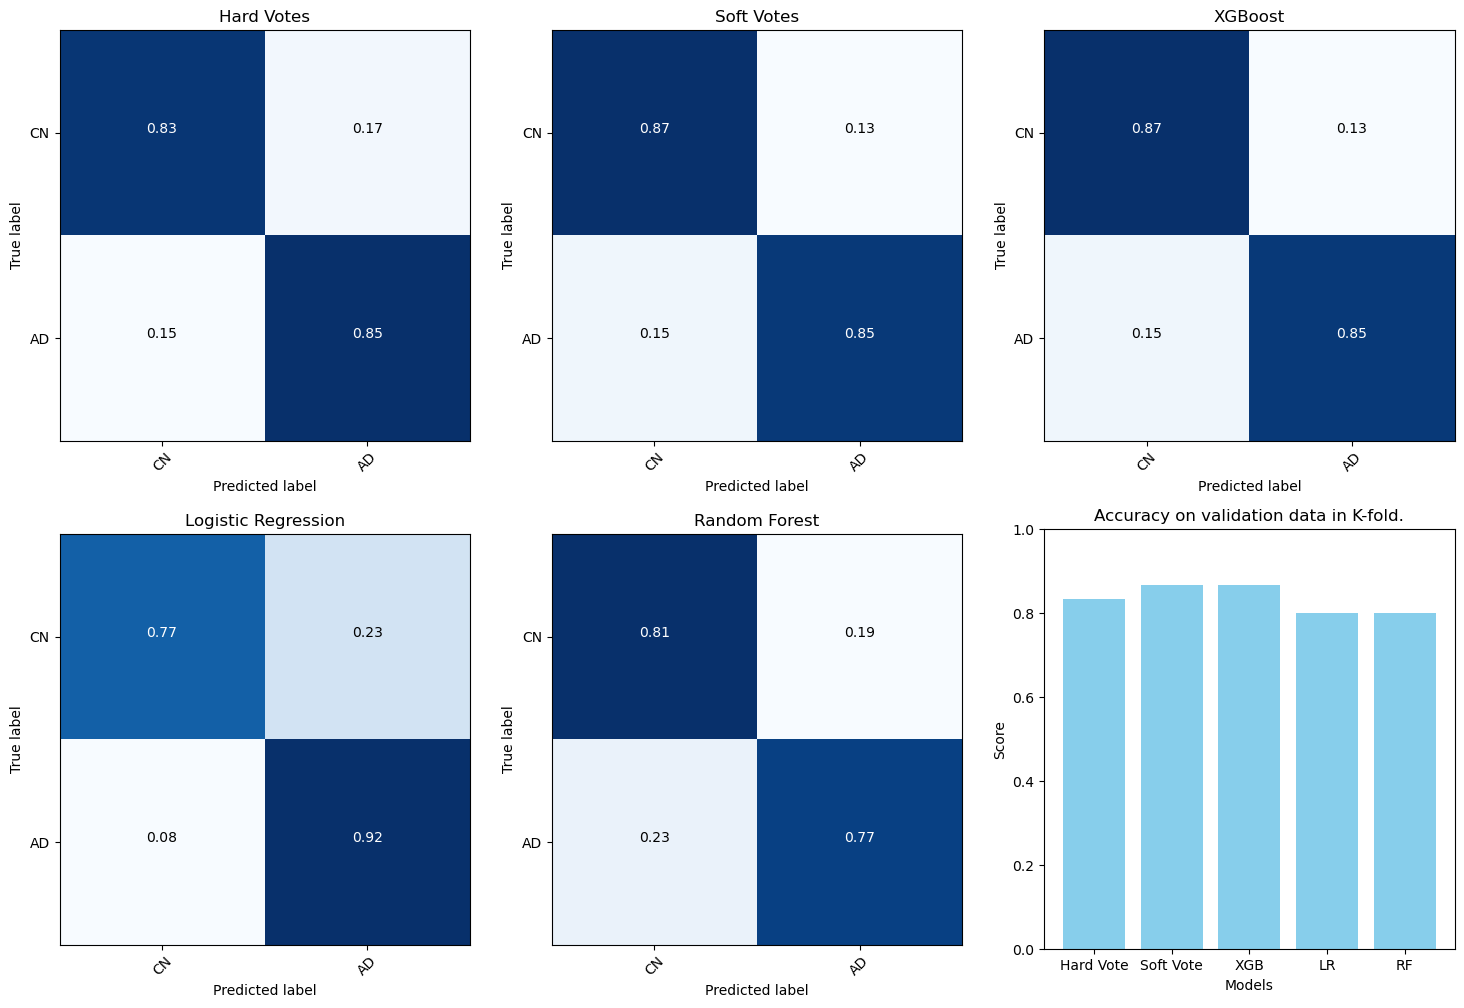

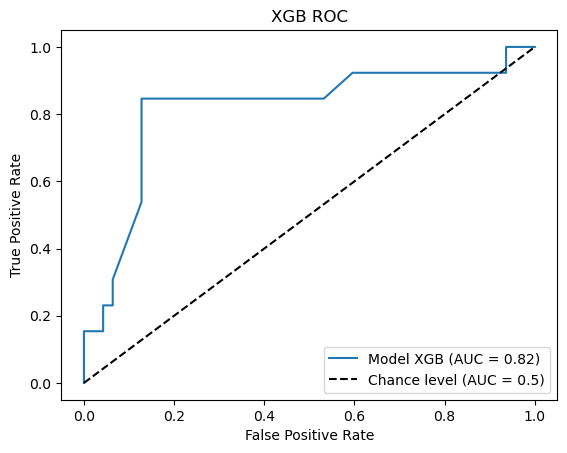

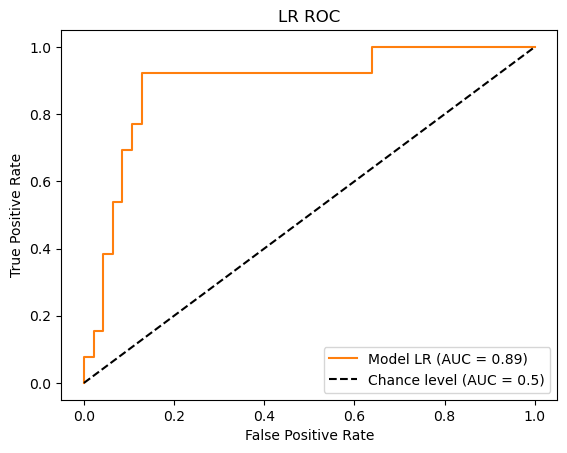

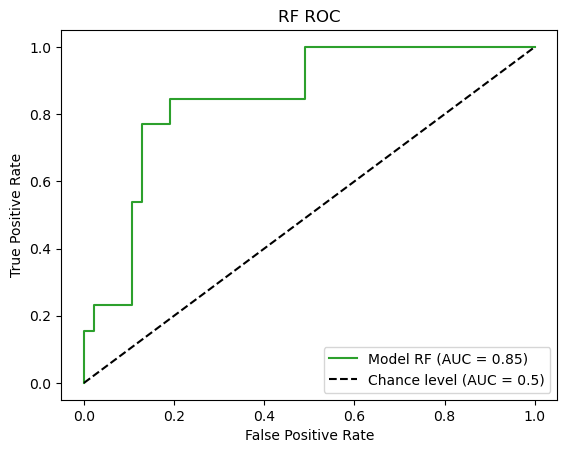

In [74]:
#Combining K-fold results.
get_scores(all_models, votes, y_true, get_graphs=True)

['P17174', 'Q13555']


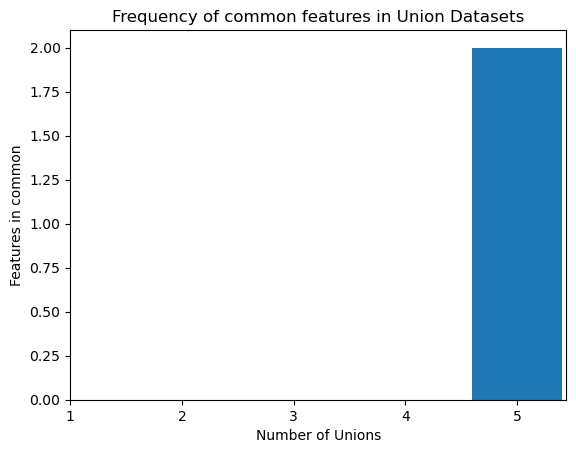

In [75]:
all_unions = [lst for lst in df_unions.values()]

all_features_in_all_unions = [item for sublist in all_unions for item in sublist]

feature_occurences = Counter(all_features_in_all_unions)

filtered_counter = Counter({key: count for key, count in feature_occurences.items() if count >= 5})
print(list(filtered_counter.keys()))

counter_data = feature_occurences

frequencies = list(counter_data.values())

# Count the occurrences of each frequency
frequency_counts = Counter(frequencies)

# Prepare data for plotting
count_values = list(frequency_counts.keys())
counts_occurrences = list(frequency_counts.values())

# Plot the histogram
plt.bar(count_values, counts_occurrences)
plt.xlabel('Number of Unions')
plt.xticks([1,2,3,4,5])
plt.ylabel('Features in common')
plt.title('Frequency of common features in Union Datasets')
plt.show()

# Potential for Paper

### Boxplots

#### Load Data

In [32]:
#Proteins
missingness = 0.0
imputer = SampMin(strategy="SampMin", missing_values=np.nan)

df_protein_median_all = pd.read_csv('Data//data files//iNPH_data_protein_median.csv', index_col=0)

df_protein_lumbar, _, _ = df_cleaner_pipeline(df_protein_median_all, "L", sample="Protein", max_missingness=missingness)
df_protein_ventricular, _, _ = df_cleaner_pipeline(df_protein_median_all, "V", sample="Protein", max_missingness=missingness)

df_p_l, y_test_l = boxplot_cleaner(df_protein_median_all, "L", sample="Protein")
df_p_v, y_test_v = boxplot_cleaner(df_protein_median_all, "V", sample="Protein")

#Peptides
df_peptide_median_all = pd.read_csv('Data//data files//iNPH_data_peptide_median.csv', index_col=0)

df_peptide_lumbar, y_l, _ = df_cleaner_pipeline(df_peptide_median_all, "L", sample="Peptide", max_missingness=missingness)
df_peptide_ventricular, y_v, _ = df_cleaner_pipeline(df_peptide_median_all, "V", sample="Peptide", max_missingness=missingness)

df_pep_l, y_test_l = boxplot_cleaner(df_peptide_median_all, "L", sample="Peptide")
df_pep_v, y_test_v = boxplot_cleaner(df_peptide_median_all, "V", sample="Peptide")

#### Plotting

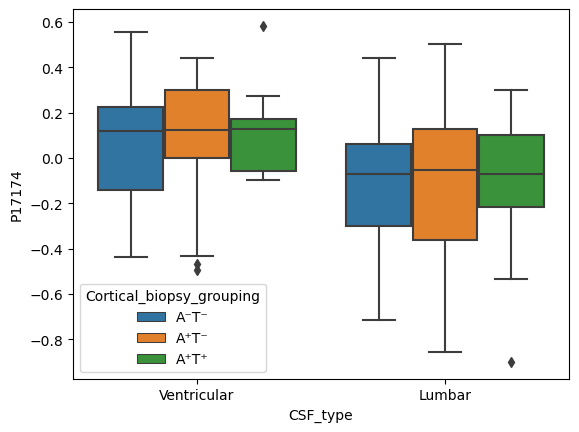

In [33]:
#Protein boxplot cleaner (Untempored data)
staging(df_p_l, df_p_v, y_test_l, y_test_v, "P17174")

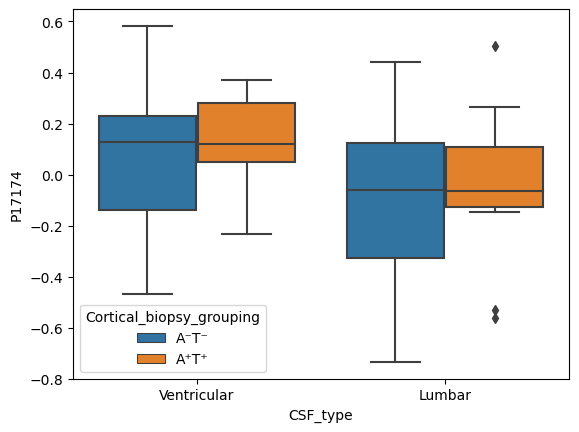

In [34]:
#Protein df_cleaner (tempored) data)
staging(df_protein_lumbar, df_protein_ventricular, y_l, y_v, "P17174")


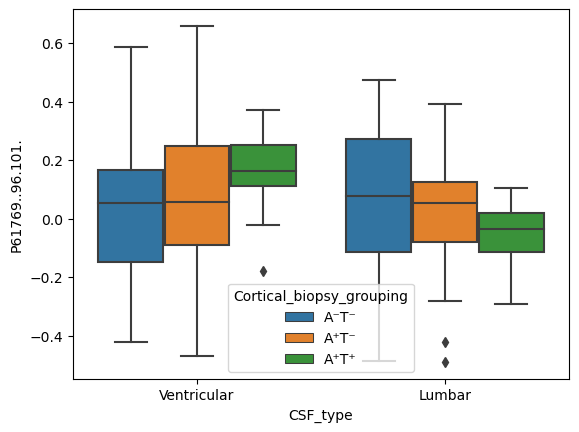

In [35]:
#Peptide boxplot cleaner (Untempored data)
staging(df_pep_l, df_pep_v, y_test_l, y_test_v, 'P61769..96.101.')

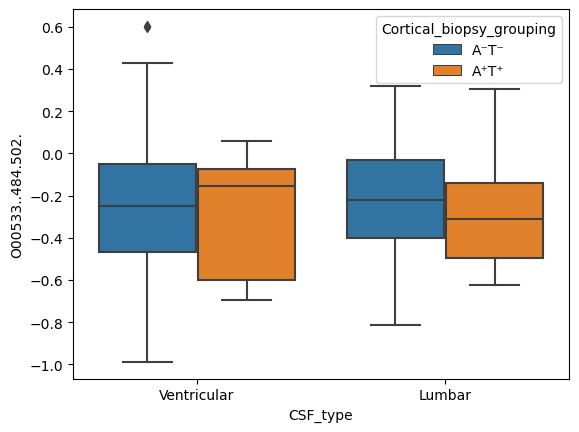

In [36]:
#Peptide df_cleaner (tempored) data)
staging(df_peptide_lumbar, df_peptide_ventricular, y_l, y_v, 'O00533..484.502.')

# Needs to be redone for binary, but are good.

### F1-score vs n-Union

In [ ]:
#REDO
num_features = np.array([2, 4, 5, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 35, 40])

percentages = np.array([0.59, 0.64, 0.65, 0.71, 0.73, 0.74, 0.76, 0.75, 0.74, 0.80, 0.76, 0.75, 0.77, 0.75, 0.76, 0.73, 0.72, 0.71, 0.69])

degree = 3 
coefficients = np.polyfit(num_features, percentages, degree)
p = np.poly1d(coefficients)

x_fit = np.linspace(min(num_features), max(num_features), 100)
y_fit = p(x_fit)

plt.scatter(num_features, percentages)
plt.xlabel('Number of features per model')
plt.ylabel('F1-score')
plt.title('Distribution of F1-score vs. Number of features per model')

#plt.grid(True)
plt.show()

In [ ]:
#REDO
plt.scatter(num_features, percentages)
plt.plot(x_fit, y_fit, color='red', label='Approximate percentage')
plt.xlabel('Number of Features per model')
plt.ylabel('F1-score')
plt.title('Distribution of F1-score vs. Number of features per model')

predicted_percentage = p(15)
plt.axvline(x=15, color='gray', linestyle='--', label=f'Estimated F1-score for 15 features: {predicted_percentage:.2f}')

plt.legend()
plt.show()

### Avg Feature Importance

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 1 with shape (2,).

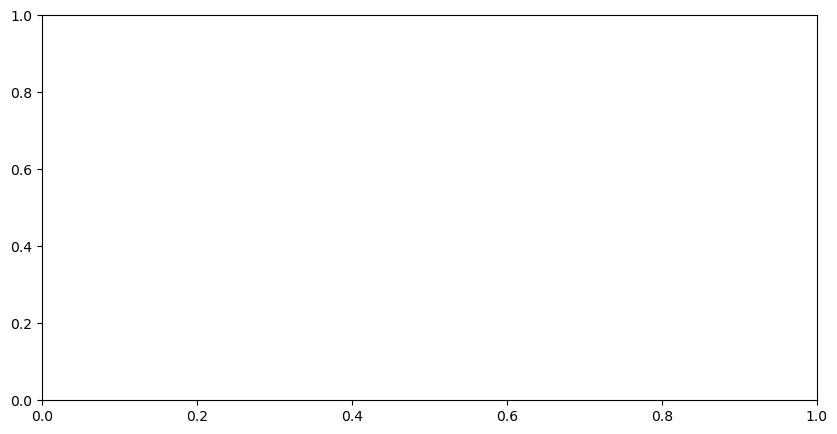

In [52]:
RF_avg_feature_importance = get_average_feature_importance(all_models, "RF", df_main)
XGB_avg_feature_importance = get_average_feature_importance(all_models, "XGB", df_main)
LR_avg_feature_importance = get_average_feature_importance(all_models, "LR", df_main)

avg_feature_importance = calculate_average([RF_avg_feature_importance, XGB_avg_feature_importance, LR_avg_feature_importance])

plot_feature_importance(avg_feature_importance, LR_avg_feature_importance, XGB_avg_feature_importance, RF_avg_feature_importance, models=["Average", "LR", "XGB", "RF"], main_model="Average")

### Correlation

In [53]:
def counter_to_features(unions, min_count):
    all_unions = [lst for lst in unions.values()]
    all_features_in_all_unions = [item for sublist in all_unions for item in sublist]
    feature_occurences = Counter(all_features_in_all_unions)
    result = [value for value, count in feature_occurences.items() if count >= min_count]

    return result

In [62]:
def get_top_feature_importance(models_features, models):
    lr_models = [all_models[key] for key in models if key.startswith("LR")]
    unions = list(models_features.values())
    top_features = counter_to_features(models_features, 5)
    
    cn_coefs = {}
    mci_coefs = {}
    ad_coefs = {}
    for model, union in zip(lr_models, unions):
        for i in range(len(model.coef_[0])):
            if union[i] in cn_coefs:
                cn_coefs[union[i]] += model.coef_[0][i]
            else:
                cn_coefs[union[i]] = model.coef_[0][i]
            if union[i] in mci_coefs:
                mci_coefs[union[i]] += model.coef_[1][i]
            else:
                mci_coefs[union[i]] = model.coef_[1][i]
            if union[i] in ad_coefs:
                ad_coefs[union[i]] += model.coef_[2][i]
            else:
                ad_coefs[union[i]] = model.coef_[2][i]

    cn_coefs = {key: value / 5 for key, value in cn_coefs.items() if key in top_features}
    mci_coefs = {key: value / 5 for key, value in mci_coefs.items() if key in top_features}
    ad_coefs = {key: value / 5 for key, value in ad_coefs.items() if key in top_features}

    return cn_coefs, mci_coefs, ad_coefs

In [63]:
cn, mci, ad = get_top_feature_importance(df_unions, all_models)

A = cn.values()
B = mci.values()
C = ad.values()
X = list(cn.keys())
 
plt.barh(X, A, color = 'r', alpha=0.65, label='CN')
plt.barh(X, B, color = 'b', alpha=0.65, label='MCI')
plt.barh(X, C, color = 'g', alpha=0.65, label='AD')
plt.title("LR Feature Correlation")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

IndexError: index 1 is out of bounds for axis 0 with size 1